## Imports

In [17]:
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import opstrat as op
from scipy.stats import norm
from yahoofinancials import YahooFinancials

# Stock Analysis

In [ ]:
ticker = "AAPL"

yahoo_financials = YahooFinancials(ticker)

beta = (yahoo_financials.get_beta())
stock = yf.Ticker(ticker)
latest_price = stock.history(period='1d')['Close'][0]
price = round(latest_price, 2) 

input = "^TNX"
output = yf.Ticker(input)
latest_price2 = output.history(period='1d')['Close'][0]
rate = round(latest_price2, 2) 

input2 = "^VIX"
output2 = yf.Ticker(input2)
latest_price3 = output2.history(period='1d')['Close'][0]
vix = round(latest_price3, 2) 

vol = vix*beta

print (ticker,"Price:",price)
print (ticker,"Beta", beta)
print ("Risk Free Rate:",rate)
print ("Volatility:",vol)

St = price
K = price
r = rate
T = 87
v= (vol*beta)

call=op.black_scholes(K=K, St=St, r=r, t=T, v=v, type='c')
print('3M ATM Call Price:',(call['value']['option value']))

put=op.black_scholes(K=K, St=St, r=r, t=T, v=v, type='p')
print('3M ATM Put Price:',(put['value']['option value']))

# Portfolio Construction

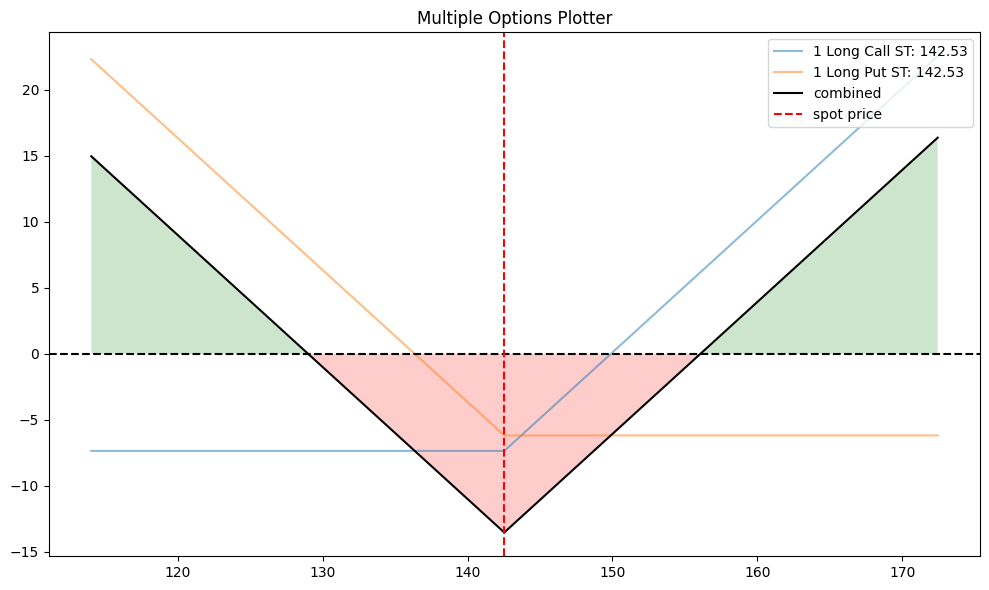

In [ ]:
op_1 = {'op_type':'c','strike':price,'tr_type':'b','op_pr':(call['value']['option value'])}
op_2 = {'op_type':'p','strike':price,'tr_type':'b','op_pr':(put['value']['option value'])}
op.multi_plotter(spot=price, op_list=[op_1,op_2])

## The Greeks

In [ ]:
print('Call Delta is:',call['greeks']['delta'])
print('Put Delta is:',put['greeks']['delta'])

Call Delta is: 0.5513137715239892
Put Delta is: -0.4486862284760108


In [ ]:
print('Call Theta is:',call['greeks']['theta'])
print('Put Theta is:',put['greeks']['theta'])

Call Theta is: -0.045425446678299744
Put Theta is: -0.03198694457370219


# Risk Assessment

## Monte Carlo Simulation

[*********************100%***********************]  1 of 1 completed


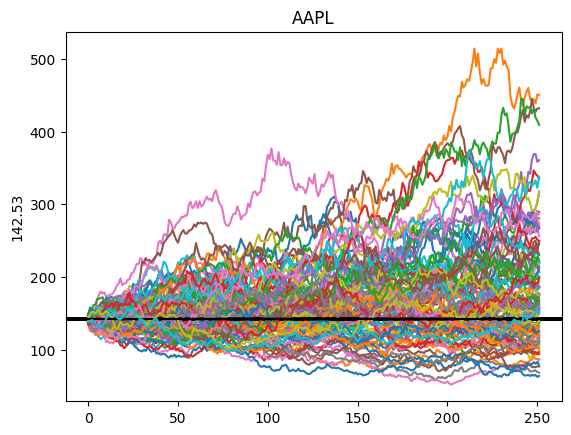

In [ ]:
df = yf.download(ticker)
returns = np.log(1+df['Adj Close'].pct_change())
mu, sigma = returns.mean(), returns.std()
sim_rets = np.random.normal(mu,sigma,252)
initial = df['Adj Close'].iloc[-1]
sim_prices = initial * (sim_rets + 1).cumprod()

for _ in range(100):
    sim_rets = np.random.normal(mu,sigma,252)
    sim_prices = initial * (sim_rets + 1).cumprod()
    plt.axhline(initial,c='k')
    plt.plot(sim_prices)
    plt.ylabel(price)
    plt.grid()
    plt.title(ticker)